In [47]:
# get samples

import csv

pairs = []

with open('data.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    rows = [row for row in reader]
    pairs = [(row[1], row[3]) for row in rows[1:]]
    
labels = []
for pair in pairs:
    label = pair[1]
    if label not in labels:
        labels.append(label)
                
print("Collected %s samples from %s classes" % (len(pairs), len(labels)))
    

Collected 1952 samples from 8 classes


In [48]:
# remove duplicates

d = {}

sample_count = 0
    
for label in labels:
    d[label] = []
    for pair in pairs:
        if pair[1] == label:
            if pair[0] not in d[label]:
                d[label].append(pair[0])
                sample_count += 1
                       
print("Found %s samples after removing duplicates." % sample_count)
for label in labels:
        print(label, len(d[label]))


Found 1626 samples after removing duplicates.
description 243
single-select 522
rate 233
multi-select 111
textarea 443
matrix-likert 62
number 6
rank 6


In [49]:
# collect labels (question types)

texts = []
labels = []

for key in d.keys():
    for text in d[key]:
        texts.append(text)
        if key == "description":
            labels.append(0)
        elif key == "single-select":
            labels.append(1)
        elif key == "rate":
            labels.append(2)
        elif key == "multi-select":
            labels.append(3)
        elif key == "textarea":
            labels.append(4)
        elif key == "matrix-likert":
            labels.append(5)
        elif key == "number":
            labels.append(6)
        elif key == "rank":
            labels.append(7)
                

In [50]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

maxlen = 100 # max number of tokens per text
training_samples = 500
validation_samples = 1000
max_words = 10000 # only look at top 10,000 words in vocabulary

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# samples are ordered, so shuffle them
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]

# convert integer class vectors to binary class matrices
# compatible with categorical cross entropy loss function
y_train = to_categorical(labels[:training_samples])
y_val = to_categorical(labels[training_samples: training_samples + validation_samples])



Found 2238 unique tokens.
Shape of data tensor: (1626, 100)
Shape of label tensor: (1626,)


In [51]:
# not enough data to train task-specific embeddings
# use pre-trained embeddings instead

# build embedding index mapping words to their vector representation

import os

glove_dir = 'glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [52]:
# build embedding matrix to load into embedding layer
# 0 is a placeholder and does not represent any token

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [54]:
# model definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='sigmoid'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
Total params: 1,320,296
Trainable params: 1,320,296
Non-trainable params: 0
_________________________________________________________________


In [56]:
# load embedding matrix into embedding layer
# freeze embedding layer

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [57]:

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 500 samples, validate on 1000 samples
Epoch 1/10
500/500 [==============================] - 1s 1ms/step - loss: 1.7351 - acc: 0.2240 - val_loss: 1.5958 - val_acc: 0.3030
Epoch 2/10
500/500 [==============================] - 0s 344us/step - loss: 1.3559 - acc: 0.3760 - val_loss: 1.5477 - val_acc: 0.3640
Epoch 3/10
500/500 [==============================] - 0s 362us/step - loss: 1.0813 - acc: 0.5780 - val_loss: 1.4770 - val_acc: 0.4600
Epoch 4/10
500/500 [==============================] - 0s 416us/step - loss: 0.8303 - acc: 0.7080 - val_loss: 1.4469 - val_acc: 0.4930
Epoch 5/10
500/500 [==============================] - 0s 369us/step - loss: 0.6006 - acc: 0.8100 - val_loss: 1.4773 - val_acc: 0.4880
Epoch 6/10
500/500 [==============================] - 0s 370us/step - loss: 0.4931 - acc: 0.8560 - val_loss: 1.7423 - val_acc: 0.4690
Epoch 7/10
500/500 [==============================] - 0s 369us/step - loss: 0.3820 - acc: 0.9040 - val_loss: 1.5892 - val_acc: 0.4920
Epoch 8/10
500/50

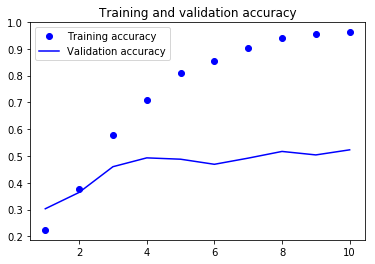

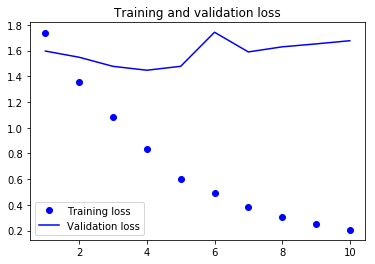

In [58]:
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
